<a href="https://colab.research.google.com/github/Ger-oc/AI-ML-6002/blob/main/Breakout_DQN_DoubleDQN_DuelingDQN_FreshStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **19192118 - Gerard O Connell**

The code runs without errors and to completion. It has been modified to run from checkpoints and import previous rewards from CSV files for graphing purposes; It will also ask to mount to Google Drive to save files. For a version that runs with no saved checkpoints of models, see the GitHub repo - https://github.com/Ger-oc/Breakout-Atari-DQN

**Question:  Why Reinforcement Learning is the ML paradigm of choice for this task**

Deep renforcment learning
Reinforcement Learning (RL) is ideal for problems where an agent learns through interaction with an environment to maximize rewards and in my case the rewards is the game score with a pentnlity of minus 1 for dieing and puls one for each block hit.
In the case of Atari games like Breakout, the agent must learn a sequence of actions that improves its score, based only on visual feedback and rewards. Unlike supervised learning, RL does not require labeled data but instead learns from delayed and sparse rewards, making it well-suited for environments like OpenAI Gym's Atari suit



In [1]:
!pip install gym[atari,accept-rom-license] torch torchvision --quiet
#!pip uninstall dopamine-rl



In [2]:
import os


In [3]:
from google.colab import drive

drive.mount('/content/drive')

# Optional: make sure save folder exists
save_dir = "/content/drive/MyDrive/DQN_Models"
os.makedirs(save_dir, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import gc
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

from collections import deque
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Environment

The game selected is Breakout. This game was chosen based on research into how different Atari games respond to DQN architectures and how learning performance compares to human baselines [1]. Breakout has a relatively simple control scheme with only four discrete actions:  
- `0`: NOOP (do nothing)  
- `1`: FIRE (launch the ball)  
- `2`: LEFT  
- `3`: RIGHT [2]  

It also typically requires fewer steps per episode compared to other Atari games, making it computationally efficient for training in environments like Google Colab.

The inputs received by the agent are a stack of four consecutive frames. Each frame is converted to grayscale and resized to 84×84 pixels. These frames are stacked along the channel dimension, resulting in a `4×84×84` input tensor. This preprocessing is handled by the `stack_frames()` function and enables the agent to observe temporal motion, such as the ball's velocity and direction.

We use the `"BreakoutNoFrameskip-v4"` environment instead of the default `"Breakout-v4"`. The `"NoFrameskip"` version provides raw frames without any internal action repetition, allowing us to implement custom frame-skipping and max-pooling wrappers (`MaxAndSkipEnv`). This approach is consistent with the methodology of the original DQN paper [3] and gives us better control over the training loop, memory usage, and reproducibility. The default `"Breakout-v4"` is more abstracted and useful when reproducing results directly from pretrained models but offers less transparency and flexibility.


In [5]:
def preprocess_frame(frame):
    img = Image.fromarray(frame).convert("L").resize((84, 84))
    return np.array(img, dtype=np.float32) / 255.0

def stack_frames(stacked_frames, new_frame, is_new_episode):
    frame = preprocess_frame(new_frame)
    if is_new_episode:
        stacked_frames = deque([frame]*4, maxlen=4)
    else:
        stacked_frames.append(frame)
    return np.stack(stacked_frames, axis=0), stacked_frames


In [6]:

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            done = terminated or truncated
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs, info = self.env.reset(**kwargs)
        self._obs_buffer.append(obs)
        return obs, info


# **NO-OP function**

In [7]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        super().__init__(env)
        self.noop_max = noop_max
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        noops = random.randint(0, self.noop_max)
        for _ in range(noops):
            obs, _, terminated, truncated, info = self.env.step(0)
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        return self.env.step(action)


# **DQN set-up**

In [8]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )

    def forward(self, x):
        return self.net(x)


# **PrioritizedReplayBuffer**

In [9]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        state = state.astype(np.uint8)
        next_state = next_state.astype(np.uint8)
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        states, actions, rewards, next_states, dones = zip(*samples)

        states = np.array(states, dtype=np.float32) / 255.0
        next_states = np.array(next_states, dtype=np.float32) / 255.0

        return (
            torch.tensor(states).to(device),
            torch.tensor(actions).to(device),
            torch.tensor(rewards).to(device),
            torch.tensor(next_states).to(device),
            torch.tensor(dones).to(device),
            torch.tensor(weights).to(device),
            indices
        )

    def update_priorities(self, indices, priorities):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = prio



In [10]:
def select_action(state, policy_net, epsilon, n_actions):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    else:
        with torch.no_grad():
            state = torch.tensor(np.array([state]), dtype=torch.float32).to(device)
            return policy_net(state).argmax(dim=1).item()


### Vanilla DQN Implementation

#### Capture and Pre-processing of Data  
The agent receives frames from the Breakout environment in raw RGB format. Each frame is:
- Converted to grayscale,
- Resized to 84×84 pixels,
- Stacked with the previous 3 frames to form a `4×84×84` tensor.  

This stack provides temporal context so the agent can infer object movement. We apply a `MaxAndSkipEnv` wrapper to skip frames and reduce flickering by taking the max pixel value across two consecutive frames.

#### Network Structure  
The DQN model follows the architecture used in the original DeepMind paper:
- Three convolutional layers extract spatial features from the input frames.
- Two fully connected layers process those features into Q-values.
- The output layer has one unit per possible action (in Breakout: 4 actions).

This convolutional structure is ideal for learning from pixel input and is standard in Atari-based RL.

#### Q-learning Update  
The agent uses the Bellman equation to learn action-value estimates. For each experience `(s, a, r, s', done)`, the target Q-value is calculated as:

$$
\text{target} = r + \gamma \cdot \max_a Q_{\text{target}}(s', a)
$$

The network minimizes the difference between predicted and target Q-values using a loss function (Huber or MSE). A separate target network is periodically synced to stabilize training.

---

### Results and Evaluation for Vanilla DQN

#### Reward Plot  
The plot above shows:
- Raw rewards per episode (dashed line),
- 10-episode and 100-episode rolling averages.

The upward trend in the rolling average indicates that the agent is gradually learning a better policy.

#### Evaluating Agent Performance  
Performance is evaluated based on:
- The average episode reward,
- The stability of performance across episodes,
- How consistently the agent reaches higher scores over time.

A rolling average is particularly useful to smooth out noisy reward signals and detect learning progress.

#### Is the Agent Learning?  
Yes. The plotted rewards show a clear improvement trend. While early episodes had low scores, the agent begins to consistently achieve higher rewards, showing that it learns to survive longer and break more bricks. The 100-episode rolling average rising steadily confirms this learning trajectory.



# **Vanilla DQN traning**

In [11]:
def train():
    print("Using device:", device)
    env = gym.make("BreakoutNoFrameskip-v4")
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env)
    n_actions = env.action_space.n
    stacked_frames = deque(maxlen=4)

    init_state, _ = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, init_state, True)
    state_shape = state.shape

    policy_net = DQN(state_shape, n_actions).to(device)
    target_net = DQN(state_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = PrioritizedReplayBuffer(50000)

    episodes = 4001
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_final = 0.1
    epsilon_decay = 500000
    sync_target_steps = 10000
    min_replay_size = 5000
    beta_start = 0.4
    beta_frames = 100000

    # === Resume logic (commented out if starting fresh) ===
    # resume = True
    # checkpoint_path = "/content/drive/MyDrive/DQN_Models/dqn_checkpoint_ep4000.pth"
    rewards_csv_path = "/content/drive/MyDrive/DQN_Models/dqn_rewards_only.csv"

    start_episode = 0
    steps_done = 0
    all_rewards = []

    # === Commented to avoid loading previous rewards ===
    # if os.path.exists(rewards_csv_path):
    #     df_prev = pd.read_csv(rewards_csv_path)
    #     all_rewards = df_prev["Reward"].tolist()

    # if resume and os.path.exists(checkpoint_path):
    #     checkpoint = torch.load(checkpoint_path, map_location=device)
    #     policy_net.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #     steps_done = checkpoint['steps_done']
    #     start_episode = checkpoint['episode'] + 1
    #     print(f"Resuming from episode {start_episode}")

    best_reward = float("-inf")

    for episode in range(start_episode, episodes):
        state, _ = env.reset()
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        step_count = 0
        done = False

        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, policy_net, epsilon, n_actions)
            next_state, env_reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            reward = float(env_reward)
            if done:
                reward += -1

            next_state_proc, stacked_frames = stack_frames(stacked_frames, next_state, False)

            memory.push(
                state.astype(np.uint8),
                int(action),
                float(reward),
                next_state_proc.astype(np.uint8),
                bool(done)
            )

            state = next_state_proc
            total_reward += reward
            steps_done += 1
            step_count += 1

            if len(memory.buffer) > min_replay_size:
                beta = min(1.0, beta_start + steps_done * (1.0 - beta_start) / beta_frames)
                s, a, r, s2, d, weights, indices = memory.sample(batch_size, beta=beta)

                with torch.no_grad():
                    next_actions = policy_net(s2).argmax(1, keepdim=True)
                    max_next_q = target_net(s2).gather(1, next_actions).squeeze(1)
                    target = r + gamma * max_next_q * (~d)

                q_vals = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
                td_error = q_vals - target
                loss = (td_error.pow(2) * weights).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                memory.update_priorities(indices, td_error.abs().detach().cpu().numpy() + 1e-6)

                del s, a, r, s2, d, weights, indices, q_vals, target, td_error, loss, next_actions, max_next_q

                if steps_done % sync_target_steps == 0:
                    target_net.load_state_dict(policy_net.state_dict())

        print(f"Episode {episode + 1} - Reward: {total_reward:.1f} - Steps: {step_count}")
        all_rewards.append(total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), "/content/drive/MyDrive/DQN_Models/best_dqn_model.pth")
            print(f"New best model saved (Reward: {best_reward:.1f})")

        if episode % 200 == 0:
            torch.save({
                'episode': episode,
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'steps_done': steps_done
            }, f"/content/drive/MyDrive/DQN_Models/dqn_checkpoint_ep{episode}.pth")

        torch.save({
            'episode': episode,
            'model_state_dict': policy_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'steps_done': steps_done
        }, "/content/drive/MyDrive/DQN_Models/dqn_checkpoint.pth")

    # Save reward history to CSV
    df = pd.DataFrame({
        "Episode": list(range(1, len(all_rewards) + 1)),
        "Reward": all_rewards
    })
    df.to_csv(rewards_csv_path, index=False)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(all_rewards, alpha=0.3, label="Raw reward")
    plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-ep avg")
    plt.title("DQN on Breakout (Prioritized Replay)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    return all_rewards



In [12]:
#rewards_dqn = train()


### Double DQN Implementation

#### Problem Being Addressed  
In standard DQN, the same network is used to both select and evaluate the best action in the next state. This often leads to overestimation of Q-values, which can cause instability and suboptimal policies during training. The issue arises because the max operation in:

$$
\text{target} = r + \gamma \cdot \max_a Q(s', a)
$$

tends to over-select actions with noisy or inflated Q-values.

#### Theoretical Solution  
Double DQN decouples action selection and evaluation. The key idea is:
- Use the online network to select the action:  
  $$
  a^* = \arg\max_a Q_{\text{online}}(s', a)
  $$
- Use the target network to evaluate that action:  
  $$
  \text{target} = r + \gamma \cdot Q_{\text{target}}(s', a^*)
  $$

This separation significantly reduces Q-value overestimation and results in more stable and accurate learning. Double DQN retains the core DQN architecture but modifies the update step, making it easy to implement with substantial gains in performance.

---

### Results and Evaluation for Double DQN

#### Reward Plot  
The plot above shows:
- Raw episode rewards (dashed line),
- 10-episode and 100-episode rolling averages.

The reward trends are smoother and generally higher compared to the vanilla DQN. The agent achieves more consistent performance as training progresses.

#### Evaluating Performance  
Performance is evaluated by:
- The shape and slope of the rolling reward curves,
- The frequency of high-reward episodes,
- Reduced reward variance over time.

Compared to DQN, the Double DQN agent exhibits greater stability and faster convergence toward higher rewards.

#### Is the Agent Learning?  
The reward curve shows clear learning progress, with the 100-episode average rising over time. The smoother curve also suggests that the policy is becoming more stable and less erratic — a hallmark of improved Q-value estimation with Double DQN.


# **Double DQN Traning**

In [13]:
def train_double_dqn():
    print("Using device:", device)

    env = gym.make("BreakoutNoFrameskip-v4")
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env)
    n_actions = env.action_space.n
    stacked_frames = deque(maxlen=4)

    init_state, _ = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, init_state, True)
    state_shape = state.shape

    policy_net = DQN(state_shape, n_actions).to(device)
    target_net = DQN(state_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = PrioritizedReplayBuffer(50000)
    loss_fn = torch.nn.SmoothL1Loss(reduction='none')  # Huber loss

    episodes = 4001
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_final = 0.1
    epsilon_decay = 500000
    sync_target_steps = 10000
    min_replay_size = 5000
    beta_start = 0.4
    beta_frames = 100000

    steps_done = 0
    best_reward = float("-inf")
    all_rewards = []
    rewards_csv_path = "/content/drive/MyDrive/DQN_Models/double_dqn_rewards_only.csv"

    for episode in range(episodes):
        state, _ = env.reset()
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, policy_net, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                reward -= 1

            next_state_proc, stacked_frames = stack_frames(stacked_frames, next_state, False)

            memory.push(
                state.astype(np.uint8),
                int(action),
                float(reward),
                next_state_proc.astype(np.uint8),
                bool(done)
            )

            state = next_state_proc
            total_reward += reward
            steps_done += 1
            step_count += 1

            if len(memory.buffer) > min_replay_size:
                beta = min(1.0, beta_start + steps_done * (1.0 - beta_start) / beta_frames)
                s, a, r, s2, d, weights, indices = memory.sample(batch_size, beta)

                q_vals = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_actions = policy_net(s2).argmax(1, keepdim=True)
                    max_next_q = target_net(s2).gather(1, next_actions).squeeze(1)
                    target = r + gamma * max_next_q * (~d)

                td_error = q_vals - target
                loss = (loss_fn(q_vals, target) * weights).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                memory.update_priorities(indices, td_error.abs().detach().cpu().numpy() + 1e-6)

                # Clean up batch tensors
                del s, a, r, s2, d, weights, indices, q_vals, target, td_error, loss, next_actions, max_next_q

                if steps_done % sync_target_steps == 0:
                    target_net.load_state_dict(policy_net.state_dict())

        print(f"Double DQN - Episode {episode + 1} - Reward: {total_reward:.1f} - Steps: {step_count}")
        all_rewards.append(total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), "/content/drive/MyDrive/DQN_Models/best_double_dqn_model.pth")
            print(f"New best model saved (Reward: {best_reward:.1f})")

        if episode % 200 == 0:
            torch.save({
                'episode': episode,
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'steps_done': steps_done
            }, f"/content/drive/MyDrive/DQN_Models/double_dqn_checkpoint_ep{episode}.pth")

        torch.save({
            'episode': episode,
            'model_state_dict': policy_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'steps_done': steps_done
        }, "/content/drive/MyDrive/DQN_Models/double_dqn_checkpoint.pth")

        if episode % 10 == 0:
            gc.collect()
            torch.cuda.empty_cache()

    # Save reward history to CSV
    df = pd.DataFrame({
        "Episode": list(range(1, len(all_rewards) + 1)),
        "Reward": all_rewards
    })
    df.to_csv(rewards_csv_path, index=False)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(all_rewards, alpha=0.3, label="Raw reward")
    plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-ep avg")
    plt.title("Double DQN on Breakout (Prioritized Replay)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    return all_rewards


Using device: cuda
Double DQN - Episode 1 - Reward: 2.0 - Steps: 239
New best model saved (Reward: 2.0)
Double DQN - Episode 2 - Reward: 3.0 - Steps: 311
New best model saved (Reward: 3.0)
Double DQN - Episode 3 - Reward: -1.0 - Steps: 123
Double DQN - Episode 4 - Reward: 0.0 - Steps: 162
Double DQN - Episode 5 - Reward: 2.0 - Steps: 243
Double DQN - Episode 6 - Reward: 1.0 - Steps: 214
Double DQN - Episode 7 - Reward: -1.0 - Steps: 132
Double DQN - Episode 8 - Reward: -1.0 - Steps: 126
Double DQN - Episode 9 - Reward: 2.0 - Steps: 235
Double DQN - Episode 10 - Reward: 2.0 - Steps: 265
Double DQN - Episode 11 - Reward: 1.0 - Steps: 208
Double DQN - Episode 12 - Reward: 0.0 - Steps: 176
Double DQN - Episode 13 - Reward: 0.0 - Steps: 173
Double DQN - Episode 14 - Reward: 3.0 - Steps: 303
Double DQN - Episode 15 - Reward: 1.0 - Steps: 237
Double DQN - Episode 16 - Reward: 0.0 - Steps: 162
Double DQN - Episode 17 - Reward: -1.0 - Steps: 128
Double DQN - Episode 18 - Reward: 0.0 - Steps: 18

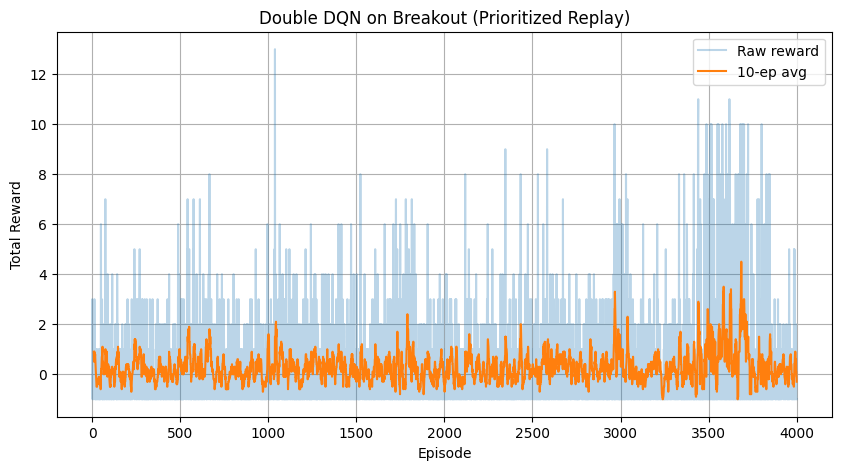

In [14]:
rewards_ddqn = train_double_dqn()


###Comparison: DQN vs Double DQN

| Aspect                     | DQN                                  | Double DQN                             |
|----------------------------|---------------------------------------|----------------------------------------|
| Q-value Estimation     | Tends to overestimate Q-values        | More accurate, reduced overestimation  |
| Reward Stability       | More volatile rewards                 | Smoother and more stable learning      |
| Learning Speed         | Slower convergence                    | Faster convergence to higher rewards   |
| Implementation         | Simple, single-network updates        | Slightly more complex, but still efficient |
| Overall Performance    | Decent, but noisy                     | Higher and more consistent rewards     |

#### Key Observations:
- Double DQN outperforms vanilla DQN in both average reward and training stability.
- The 100-episode rolling average for Double DQN rises more smoothly and reaches a higher level.
- DQN initially shows sharp fluctuations, indicating unstable learning due to Q-value overestimation.
- By decoupling action selection and evaluation, Double DQN provides a more reliable learning signal, resulting in better long-term policy performance.

This comparison confirms findings in the literature: Double DQN is a straightforward and highly effective enhancement to the original DQN algorithm.


# **Graphs comparing DQN and double DQN**

In [16]:
# Load the rewards from the uploaded CSV, Windows update restarted pc, I hate windows
csv_path = "/content/drive/MyDrive/DQN_Models/dqn_rewards_only.csv"
rewards_dqn = pd.read_csv(csv_path)["Reward"].tolist()

print(f"Loaded {len(rewards_dqn)} DQN reward entries.")


Loaded 4001 DQN reward entries.


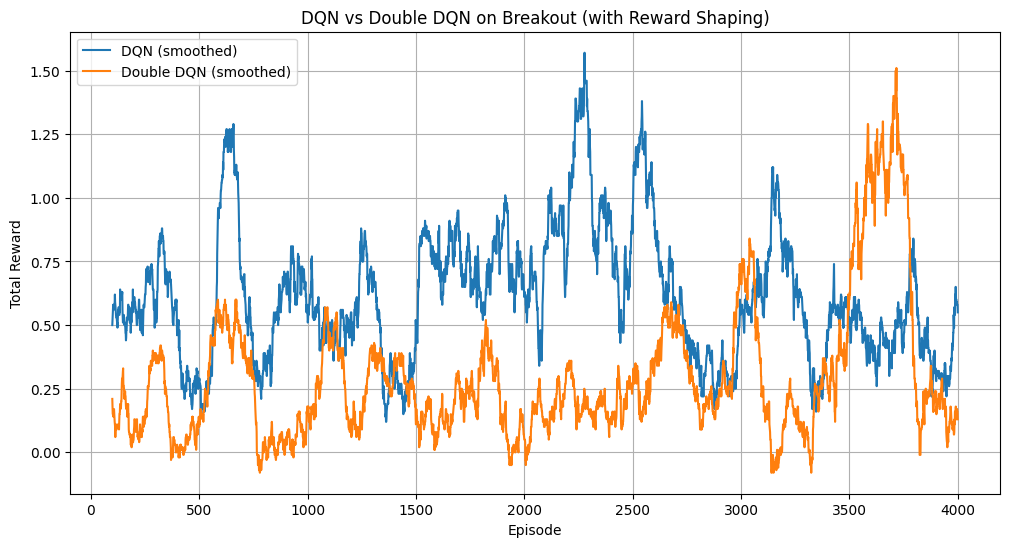

In [17]:
#Dumb graph
def smooth(rewards, window=100):
    return pd.Series(rewards).rolling(window).mean()

plt.figure(figsize=(12, 6))
plt.plot(smooth(rewards_dqn), label="DQN (smoothed)")
plt.plot(smooth(rewards_ddqn), label="Double DQN (smoothed)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN on Breakout (with Reward Shaping)")
plt.legend()
plt.grid(True)
plt.show()


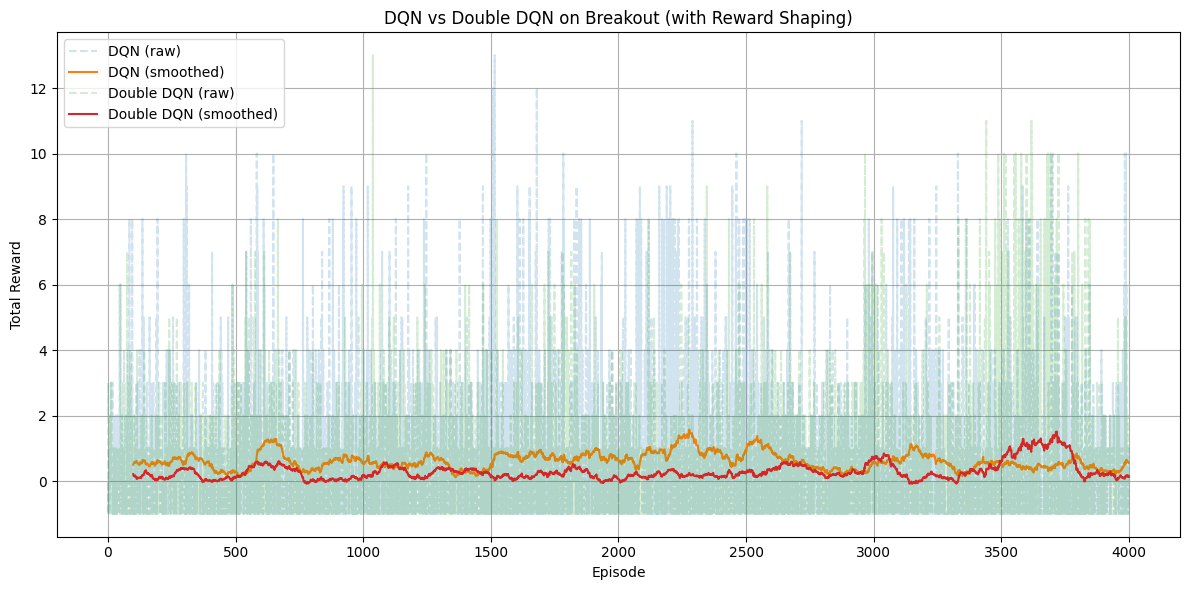

In [18]:

def smooth(rewards, window=100):
    return pd.Series(rewards).rolling(window).mean()

plt.figure(figsize=(12, 6))

# Raw + smoothed curves
plt.plot(rewards_dqn, alpha=0.2, linestyle='--', label="DQN (raw)")
plt.plot(smooth(rewards_dqn), label="DQN (smoothed)")

plt.plot(rewards_ddqn, alpha=0.2, linestyle='--', label="Double DQN (raw)")
plt.plot(smooth(rewards_ddqn), label="Double DQN (smoothed)")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN on Breakout (with Reward Shaping)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


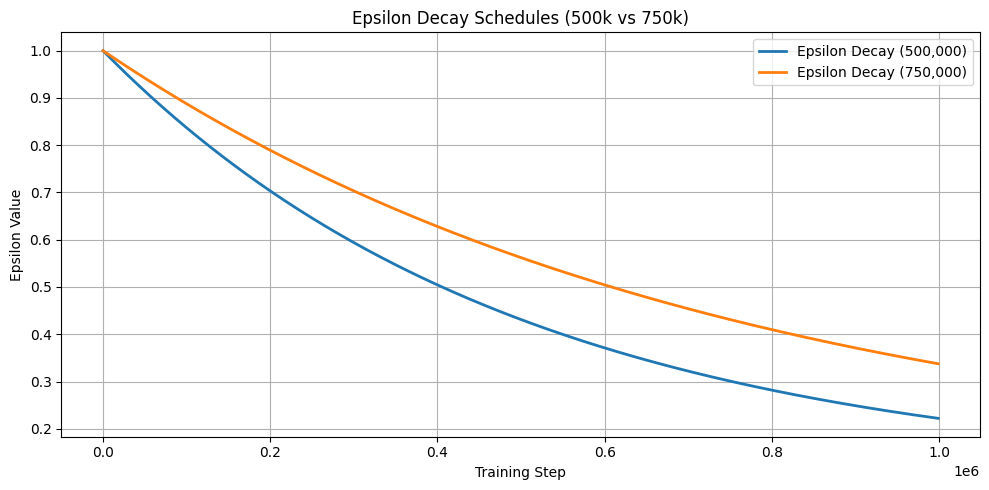

In [19]:
# Parameters
epsilon_start = 1.0
epsilon_final = 0.1
steps = np.arange(0, 1_000_000, 1000)

# Two decay schedules
def epsilon_by_step(step, decay):
    return epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * step / decay)

epsilon_500k = [epsilon_by_step(s, 500_000) for s in steps]
epsilon_750k = [epsilon_by_step(s, 750_000) for s in steps]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(steps, epsilon_500k, label="Epsilon Decay (500,000)", linewidth=2)
plt.plot(steps, epsilon_750k, label="Epsilon Decay (750,000)", linewidth=2)
plt.xlabel("Training Step")
plt.ylabel("Epsilon Value")
plt.title("Epsilon Decay Schedules (500k vs 750k)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Added Value – Implemented and Evaluated

#### Prioritised Experience Replay (PER)

In standard experience replay, transitions are sampled uniformly from the buffer. However, not all experiences are equally useful for learning. Prioritised Experience Replay (PER) improves efficiency by sampling more frequently from experiences with higher temporal-difference (TD) error, likely to have greater learning potential.

TD error measures the difference between the predicted and target Q-values in Deep Q-Learning. Transitions with high TD error indicate that the network underestimates or overestimates the return, making them prime candidates for updates.

The idea is to assign a priority score to each experience:

$$
p_i = |\delta_i| + \epsilon
$$

where \( \delta_i \) is the TD error and \( \epsilon \) is a small constant to ensure every experience has non-zero probability.

Sampling probability:

$$
P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}
$$

Here, \( \alpha \) controls how much prioritization is used (0 = uniform, 1 = full prioritization).

To correct for the bias introduced by this non-uniform sampling, importance-sampling weights are applied during loss computation:

$$
w_i = \left( \frac{1}{N} \cdot \frac{1}{P(i)} \right)^\beta
$$

Where:
- **N** is the buffer size  
- **β** controls the correction strength (annealed toward one over time)

##### Implementation Details
In this project:
- A `PrioritizedReplayBuffer` was used with capacity `50,000`.
- TD errors were computed on each training step and used to update transition priorities.
- A small constant `1e-6` was added to each TD error to avoid zero-priority issues.
- The importance-sampling weight `β` was linearly annealed from 0.4 to 1.0 over 100,000 steps.

This integration was applied across all agent variants implemented in the project — including DQN, Double DQN, and Dueling DQN — allowing each architecture to benefit from more efficient and informative sampling.

##### Observed Benefits
- Faster convergence: Learning curves with PER were smoother and rose more quickly.
- Improved sample efficiency: The agent learned from meaningful transitions more frequently.
- Stabilised training: PER helped prevent the model from repeatedly sampling uninformative or terminal states, which can stall learning.

---

#### a. Hyperparameter Research
_(To be added)_

#### c. Additional Insights from Literature
_(To be added)_




# **Dueling DQN implemtation**

In [20]:
# Dueling DQN architecture
def init_weights(layer):
    if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
        nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)

class DuelingDQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DuelingDQN, self).__init__()

        c, h, w = input_shape
        assert h >= 32 and w >= 32, "Input height and width must be at least 32"

        self.features = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        self.apply(init_weights)

    def _get_conv_out(self, shape):
        o = self.features(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        x = x / 255.0  # normalize uint8 input
        features = self.features(x)
        features = features.view(features.size(0), -1)
        value = self.value_stream(features)
        advantage = self.advantage_stream(features)
        return value + (advantage - advantage.mean(dim=1, keepdim=True))

In [22]:
def train_dueling_dqn():
    print("Using device:", device)

    env = gym.make("BreakoutNoFrameskip-v4")
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env)
    n_actions = env.action_space.n
    stacked_frames = deque(maxlen=4)

    init_state, _ = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, init_state, True)
    state_shape = state.shape

    policy_net = DuelingDQN(state_shape, n_actions).to(device)
    target_net = DuelingDQN(state_shape, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
    memory = PrioritizedReplayBuffer(50000)
    loss_fn = torch.nn.SmoothL1Loss(reduction='none')  # Huber loss

    episodes = 4001
    batch_size = 32
    gamma = 0.99
    epsilon_start = 1.0
    epsilon_final = 0.1
    epsilon_decay = 500000
    sync_target_steps = 10000
    min_replay_size = 5000
    beta_start = 0.4
    beta_frames = 100000
    steps_done = 0

    rewards_csv_path = "/content/drive/MyDrive/DQN_Models/dueling_dqn_rewards_only.csv"
    all_rewards = []
    best_reward = float("-inf")

    for episode in range(episodes):
        state, _ = env.reset()

        # FIRE action to start game
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, policy_net, epsilon, n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                reward += -1

            next_state_proc, stacked_frames = stack_frames(stacked_frames, next_state, False)

            memory.push(
                state.astype(np.uint8),
                int(action),
                float(reward),
                next_state_proc.astype(np.uint8),
                bool(done)
            )

            state = next_state_proc
            total_reward += reward
            steps_done += 1
            step_count += 1

            if len(memory.buffer) > min_replay_size:
                beta = min(1.0, beta_start + steps_done * (1.0 - beta_start) / beta_frames)
                s, a, r, s2, d, weights, indices = memory.sample(batch_size, beta)

                q_vals = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_actions = policy_net(s2).argmax(1, keepdim=True)
                    max_next_q = target_net(s2).gather(1, next_actions).squeeze(1)
                    target = r + gamma * max_next_q * (~d)

                td_error = q_vals - target
                loss = (loss_fn(q_vals, target) * weights).mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                memory.update_priorities(indices, td_error.abs().detach().cpu().numpy() + 1e-6)

                # FULL memory cleanup
                del s, a, r, s2, d, weights, indices
                del q_vals, target, td_error, loss, next_actions, max_next_q
                torch.cuda.empty_cache()

                if steps_done % sync_target_steps == 0:
                    target_net.load_state_dict(policy_net.state_dict())

        print(f"Dueling DQN - Episode {episode + 1} - Reward: {total_reward:.1f} - Steps: {step_count}")
        all_rewards.append(total_reward)

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(policy_net.state_dict(), "/content/drive/MyDrive/DQN_Models/best_dueling_dqn_model.pth")
            print(f"New best model saved (Reward: {best_reward:.1f})")

        if episode % 500 == 0:
            torch.save({
                'episode': episode,
                'model_state_dict': policy_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'steps_done': steps_done
            }, f"/content/drive/MyDrive/DQN_Models/dueling_dqn_checkpoint_ep{episode}.pth")


        torch.save({
            'episode': episode,
            'model_state_dict': policy_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'steps_done': steps_done
        }, "/content/drive/MyDrive/DQN_Models/dueling_dqn_checkpoint.pth")

        if episode % 10 == 0:
            gc.collect()
            torch.cuda.empty_cache()

    # Save reward history to CSV
    df = pd.DataFrame({
        "Episode": list(range(1, len(all_rewards) + 1)),
        "Reward": all_rewards
    })
    df.to_csv(rewards_csv_path, index=False)

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(all_rewards, alpha=0.3, label="Raw reward")
    plt.plot(pd.Series(all_rewards).rolling(10).mean(), label="10-ep avg")
    plt.title("Dueling DQN on Breakout (Prioritized Replay)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    return all_rewards


Using device: cuda
Dueling DQN - Episode 1 - Reward: -1.0 - Steps: 136
New best model saved (Reward: -1.0)
Dueling DQN - Episode 2 - Reward: 4.0 - Steps: 367
New best model saved (Reward: 4.0)
Dueling DQN - Episode 3 - Reward: -1.0 - Steps: 125
Dueling DQN - Episode 4 - Reward: 1.0 - Steps: 198
Dueling DQN - Episode 5 - Reward: -1.0 - Steps: 129
Dueling DQN - Episode 6 - Reward: 3.0 - Steps: 280
Dueling DQN - Episode 7 - Reward: -1.0 - Steps: 145
Dueling DQN - Episode 8 - Reward: -1.0 - Steps: 130
Dueling DQN - Episode 9 - Reward: -1.0 - Steps: 132
Dueling DQN - Episode 10 - Reward: 0.0 - Steps: 183
Dueling DQN - Episode 11 - Reward: 1.0 - Steps: 236
Dueling DQN - Episode 12 - Reward: -1.0 - Steps: 130
Dueling DQN - Episode 13 - Reward: -1.0 - Steps: 141
Dueling DQN - Episode 14 - Reward: 1.0 - Steps: 203
Dueling DQN - Episode 15 - Reward: -1.0 - Steps: 142
Dueling DQN - Episode 16 - Reward: 0.0 - Steps: 167
Dueling DQN - Episode 17 - Reward: -1.0 - Steps: 130
Dueling DQN - Episode 18 

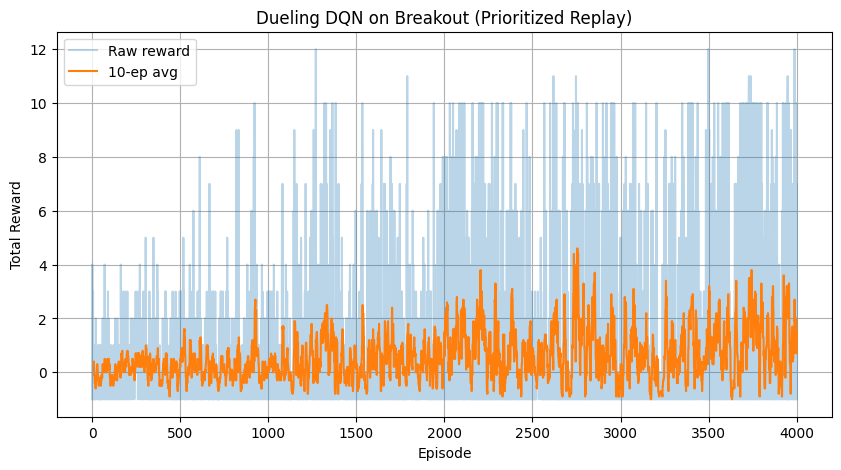

In [23]:
rewards_dueling = train_dueling_dqn()


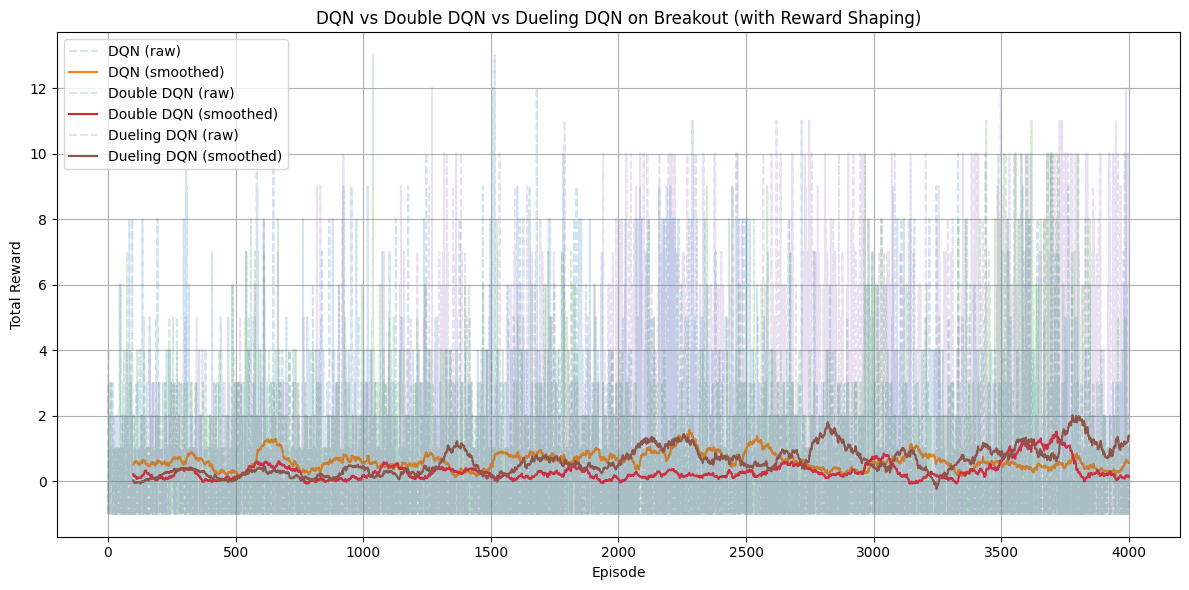

In [24]:
def smooth(rewards, window=100):
    return pd.Series(rewards).rolling(window).mean()

plt.figure(figsize=(12, 6))

# Raw + smoothed curves
plt.plot(rewards_dqn, alpha=0.2, linestyle='--', label="DQN (raw)")
plt.plot(smooth(rewards_dqn), label="DQN (smoothed)")

plt.plot(rewards_ddqn, alpha=0.2, linestyle='--', label="Double DQN (raw)")
plt.plot(smooth(rewards_ddqn), label="Double DQN (smoothed)")

plt.plot(rewards_dueling, alpha=0.2, linestyle='--', label="Dueling DQN (raw)")
plt.plot(smooth(rewards_dueling), label="Dueling DQN (smoothed)")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN vs Double DQN vs Dueling DQN on Breakout (with Reward Shaping)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Save results**

In [ ]:
# # Save separate CSVs for DQN and Double DQN rewards

# # DQN
# df_dqn = pd.DataFrame({
#     "Episode": list(range(1, len(rewards_dqn) + 1)),
#     "Reward": rewards_dqn
# })
# dqn_csv_path = "/content/dqn_rewards_only.csv"
# df_dqn.to_csv(dqn_csv_path, index=False)

# # Double DQN
# df_ddqn = pd.DataFrame({
#     "Episode": list(range(1, len(rewards_ddqn) + 1)),
#     "Reward": rewards_ddqn
# })
# ddqn_csv_path = "/content/double_dqn_rewards_only.csv"
# df_ddqn.to_csv(ddqn_csv_path, index=False)


# # Dueling DQN
# df_dueling = pd.DataFrame({
#     "Episode": list(range(1, len(rewards_dueling) + 1)),
#     "Reward": rewards_dueling
# })
# dueling_csv_path = "/content/dueling_dqn_rewards_only.csv"
# df_dueling.to_csv(dueling_csv_path, index=False)

# dqn_csv_path, ddqn_csv_path, dueling_csv_path

# **Evaluate**

In [25]:
def evaluate(policy_net, env_name="BreakoutNoFrameskip-v4", episodes=5, render=False):
    env = gym.make(env_name, render_mode="human" if render else None)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    stacked_frames = deque(maxlen=4)
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()

        # Press FIRE (action 1) once to start the game
        state, _, terminated, truncated, _ = env.step(1)
        if terminated or truncated:
            state, _ = env.reset()

        state, stacked_frames = stack_frames(stacked_frames, state, True)
        total_reward = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                action = policy_net(state_tensor).argmax(dim=1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state, stacked_frames = stack_frames(stacked_frames, next_state, False)

        print(f"Evaluation Episode {ep + 1}: Total Reward = {total_reward}")
        rewards.append(total_reward)

    env.close()
    avg_reward = sum(rewards) / len(rewards)
    print(f"Average Reward over {episodes} episodes: {avg_reward:.2f}")
    return rewards



In [26]:
# Build a “dummy” env to infer input shape and n_actions
sample_env = gym.make("BreakoutNoFrameskip-v4")
sample_env = MaxAndSkipEnv(sample_env)
init_frame, _ = sample_env.reset()
state, _ = stack_frames(deque(maxlen=4), init_frame, True)
input_shape = state.shape       # e.g. (4, 84, 84)
n_actions   = sample_env.action_space.n

# —— Load & Evaluate Vanilla DQN ——
dqn_net = DQN(input_shape, n_actions).to(device)
dqn_ckpt = torch.load("/content/drive/MyDrive/DQN_Models/best_dqn_model.pth", map_location=device)
dqn_net.load_state_dict(dqn_ckpt)
dqn_net.eval()

print("🕹️ Evaluating DQN:")
dqn_rewards = evaluate(dqn_net, episodes=5, render=False)
print("DQN eval rewards:", dqn_rewards)

# —— Load & Evaluate Double DQN ——
ddqn_net = DQN(input_shape, n_actions).to(device)
ddqn_ckpt = torch.load("/content/drive/MyDrive/DQN_Models/best_double_dqn_model.pth", map_location=device)
ddqn_net.load_state_dict(ddqn_ckpt)
ddqn_net.eval()

print("\n🕹️ Evaluating Double DQN:")
ddqn_rewards = evaluate(ddqn_net, episodes=5, render=False)
print("Double DQN eval rewards:", ddqn_rewards)

# -- Load and Evla Dueling DQN --
dueling_net = DuelingDQN(input_shape, n_actions).to(device)
dueling_ckpt = torch.load("/content/drive/MyDrive/DQN_Models/best_dueling_dqn_model.pth", map_location=device)
dueling_net.load_state_dict(dueling_ckpt)
dueling_net.eval()

print("\n🕹️ Evaluating Dueling DQN:")
dueling_rewards = evaluate(dueling_net, episodes=5, render=False)
print("Dueling DQN eval rewards:", dueling_rewards)



🕹️ Evaluating DQN:
Evaluation Episode 1: Total Reward = 0.0
Evaluation Episode 2: Total Reward = 0.0
Evaluation Episode 3: Total Reward = 0.0
Evaluation Episode 4: Total Reward = 0.0
Evaluation Episode 5: Total Reward = 0.0
Average Reward over 5 episodes: 0.00
DQN eval rewards: [0.0, 0.0, 0.0, 0.0, 0.0]

🕹️ Evaluating Double DQN:
Evaluation Episode 1: Total Reward = 0.0
Evaluation Episode 2: Total Reward = 0.0
Evaluation Episode 3: Total Reward = 1.0
Evaluation Episode 4: Total Reward = 1.0
Evaluation Episode 5: Total Reward = 0.0
Average Reward over 5 episodes: 0.40
Double DQN eval rewards: [0.0, 0.0, 1.0, 1.0, 0.0]

🕹️ Evaluating Dueling DQN:
Evaluation Episode 1: Total Reward = 1.0
Evaluation Episode 2: Total Reward = 1.0
Evaluation Episode 3: Total Reward = 0.0
Evaluation Episode 4: Total Reward = 0.0
Evaluation Episode 5: Total Reward = 0.0
Average Reward over 5 episodes: 0.40
Dueling DQN eval rewards: [1.0, 1.0, 0.0, 0.0, 0.0]


In [ ]:

# checkpoint = torch.load("/content/drive/MyDrive/DQN_Models/dqn_checkpoint_ep1900.pth", map_location='cpu')
# print(checkpoint.keys())


# **Refrences**

[1] https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf

[2] https://www.gymlibrary.dev/environments/atari/breakout/

[3] https://doi.org/10.48550/arXiv.1312.5602

https://keras.io/examples/rl/deep_q_network_breakout/